In [63]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Extemporaneous, an Improvisation Guidance Tool

## Technical Challenges

## Introduction

During the spring semester 2022, we had to develop a project for EPFL's Master course **Computer and Music** (COM-418) given by ***Prof. Paolo Prandoni***. 

Our proposal was to create a software tool capable of:
* Reading, visualizing and playing MIDI files' music.
* Suggesting and showing related musical knowledge for improvisation in real-time.

The first part essentially requires to have regular MIDI files. Since we wish not to edit music data at display time, we needed to preprocess it correctly. To do so, we had to discover the MIDI standard and how people usually use it to come up with a reasonable design to regularize them.

The second part is more vast and opens on several subjects we decided to tackle. 

One central rule of music composition is to write *in* a musical scale. In other words, composers decide to more or less follow a predefined set of notes that guarantees a musical coherence. Same can be used in improvisation: once you detect the scale being played, you can accompagny the music more easily.<br/>
Hence, we decided to implement a *Scale and Chord Suggestion System* with visualization to help the user discover this information analytically.

Naturally, we first created an abstraction that embodies scales. Then, we tried representing known scales such as *Diatonic Modes* or *Harmonic Minor* for example. But we realized that it could be more interesting to explore beyond the generally well known scope and cover more possibilites.  <br/>
Thus, we looked online to find an interesting database and connect it with our abstraction.

Finally, remained the two main technical challenges, creating an experimental metric to grade scale/chords relevancy for a set of played notes (in real-time).

We covered most of our objectives at last-minute, and realized how time-consuming it is to develop an experimental app on such short time window. We can easily say that half of the time was used for UI conception. On the other hand, being able to test with UI is also very rewarding. There are some potential severe bugs that you can encounter in our program if you do excessive/abusive sequences of actions. We hope it will work well on your machine (all mentioned modules here are implicitely those found in `music_tools`)

*Authors*: ***Manon Michel***, ***Camille Montemagni***, ***Maxime Perret***, ***Matthieu Verdet*** 

(PS: Sorry for the text quality, we were a bit tired)

---
## Regularizing Midi Files

##### We realized pretty soon that MIDI usages were really versatile. On data-side, it results in different structures that sometimes displease us. To cope with that, we created a class to manipulate decompressed MIDI with more ease.

The main aspects of MIDI are to communicates message-instance of information to alter notes and parameters on diverse devices and/or softwares. It proposes a very large panel of possibilites but also suffer from its advantages: content may look quite chaotic.<br/>
There is a system with 256 potential tracks playing on 16 distinct channels. It can only process 16 channels at once. It implies that for more than 16 musical tracks we are forced to at least use twice the same channel in the simplest case. On the other hand, some of these tracks may be present only for meta messages (not directly notes). They can alter pitch, tempo, time signatures, program parameters, etc... <br/>

Now, two kinds of extreme are possible:
* A midifile with 25 musical tracks spanning on only 3 channels with 12 meta tracks
* A midifile with a single track spanning on the 16 channels with all the meta information. 

To remedy the situation, we decided to extract all data as whole and dispacthing it:
* Either, we dispatch musical messages per channels.
* Either, we dispatch meta messages in one meta-track.

This way, we receive in any situation at most 17 tracks: 1 meta-track and 16 tracks for each channel.
Surely, it may compact previously separated tracks (2 hands on piano on 2 tracks playing 1 channel, becomes a single track), but it offers a peace of mind to continue developping the other features.

This behavior is described by the `"dispatched"` mode used by default in our class: `midi_frame.MidiFrame` (it also have a mode to leave data intact `"all"`, and another to filter out unrelevant tracks "`filtered`") <br/>
It takes for input a `mido.Midifile`, which give us the decompressed raw data.
We also use `pretty_midi.PrettyMIDI` class to synthesize the audio if required.

You can compare below, the execution of the `dispatched` midiframe and the `all` midiframe (you may need to increase you print length size).

In [64]:
from music_tools.midi_frame import MidiFrame
from mido import MidiFile
from pretty_midi import PrettyMIDI

MIDI_FOLDER = "MIDI_Files/"
midi_filename = MIDI_FOLDER + "Toto - Africa.mid"

midofile = MidiFile(filename=midi_filename)

print("---" * 30)
midiframe = MidiFrame(midofile=midofile, info_type="all")
print(midiframe)

print("---" * 30)
midiframe = MidiFrame(midofile=midofile, info_type="dispatched")
print(midiframe)

------------------------------------------------------------------------------------------
Info type: all
Filename: MIDI_Files/Toto - Africa.mid
Midi type: 1
Track count: 30
Music track count: 24
Ticks per beat: 384
Length: 252.67252702087595
 (Meta Track):
	Meta Message count: 4
	Used Message types: sequencer_specific, time_signature, set_tempo, end_of_track
:
	Message count/channel: 1 (971)
	Meta Message count: 2
	Used Message types: note_on, program_change, key_signature, note_off, control_change, end_of_track
:
	Message count/channel: 2 (253)
	Meta Message count: 2
	Used Message types: note_on, pitchwheel, program_change, key_signature, note_off, control_change, end_of_track
:
	Message count/channel: 4 (1021)
	Meta Message count: 2
	Used Message types: note_on, program_change, key_signature, note_off, control_change, end_of_track
:
	Message count/channel: 7 (167)
	Meta Message count: 2
	Used Message types: note_on, program_change, key_signature, note_off, control_change, end_of_tra

As you could see, we observe very singuliar use of tracks in MIDI and thus it reinforces the need to regularize these files.

`MidiFrame` is one of our central piece for the rest of the programs. In addition to the `dispatch` mode, it creates for each track a `MidiTrackFrame`, which englobe and posses information contained in a `mido.MidiTrack` (you can see above the representation of each trackframe).

Each `MidiTrackFrame` does not only have global knowledge on MIDI messages and the according `mido.MidiTrack` but also can benefit from a `pandas.DataFrame` object (if computed) that collects all necessary information about notes. The minimum needed to perform musical analysis. <br/>
To compute it, it requires from `MidiFrame` its temporal converters taking in account **Tempo** and **Time Signature** changes: respectively `TicksTimeConverter` and `TicksBartimeConverter` (in module `temporal_converters`).

To avoid computing this `Dataframe` for every `MidiTrackFrame`, we do it only on data of interest. We reunite some of the channel-trackframes in a single one to be later played with and analysed. It is called `playing_track_frame` (since some of the operations can be really slow in python, you will see many time optimizations that makes the code a bir peculiar, this is one of them). <br/>
The conversion of `MidiTrack` to `DataFrame` is independent from `MidiTrackFrame` as long as you computed the converters and can be found in `midi_utils.track_to_dataframe`.

In [65]:
from music_tools.temporal_converters import TicksTimeConverter, TicksBartimeConverter 

# Takes Tempo changes in account and convert from midi "ticks" to "time" in second (based on tempos and ticks_per_beat)
time_converter : TicksTimeConverter = midiframe.converters["time"]

# Takes Time signature changes in account and convert from midi "ticks" to "bartime" in floating bar count metric (based on time signatures and ticks_per_beat)
# In bartime metric, 0.0 is the beginning of the first bar. 
# 1.0 is the end of the first bar and the beggining of the second. 
# 1.5 is at bar 1 and onset of 0.5.
bartime_converter : TicksBartimeConverter =  midiframe.converters["bartime"]

In [66]:
# Channel Selection
channels = [1,3,4]
# Making the playing track frame
midiframe.make_playing_track_frame(channels=channels)

# Showing the summary and the dataframe:
print(midiframe.playing_track_frame)
midiframe.playing_track_frame.dataframe

Playing Track:
	Message count/channel: 1 (971), 3 (1218), 4 (1021)
	Meta Message count: 1
	Used Message types: note_on, program_change, note_off, control_change, end_of_track



,index,channel,note,velocity,ticks,ticks_release,velocity_release,time,time_release,bartime,bartime_release,onset,weight
0,0,1,33,127,6128,6388,0,10.186156,10.618337,3.989583,4.158854,0.989583,0.333333
1,1,1,33,127,6416,6488,0,10.664879,10.784560,4.177083,4.223958,0.177083,1.000000
2,2,1,33,127,6608,6696,0,10.984028,11.130304,4.302083,4.359375,0.302083,0.333333
3,3,1,33,127,6800,6840,0,11.303176,11.369665,4.427083,4.453125,0.427083,0.333333
4,4,1,33,127,6896,6984,0,11.462750,11.609027,4.489583,4.546875,0.489583,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,1594,4,73,45,147056,147124,0,244.441155,244.554187,95.739583,95.783854,0.739583,0.666667
1595,1595,4,78,57,147152,147264,0,244.600730,244.786900,95.802083,95.875000,0.802083,0.333333
1596,1596,4,73,61,147152,147240,0,244.600730,244.747006,95.802083,95.859375,0.802083,0.333333
1597,1597,4,71,53,147248,147392,0,244.760304,244.999665,95.864583,95.958333,0.864583,0.333333


With both converters we can pass from one metric to the other and navigate from time to ticks to bartime and conversely. Theses metrics are distinctely interesting when there are multiple changes of tempo/time signature during the music.
If the MIDI file uses the default tempo and default time signature, the behavior will look colinearly the same for all 3.

Among the curiosities, you may have seen a column `weight`, which is an experimental metric ponderating the note onset in the measure depending on the time signature. It looks for qualifying the played note *rhythmically*, as downbeats are considered more influent for example.
To define a standardized way of computing the downbeat/upbeats, we used a made-up method (form Matthieu's previous work) to compute the importances per onset for a certain time signature numerator. It can be found at `midi_utils.get_updown_beats`. It simply consists on a prime number decomposition of the numerator. It is arbitrary but brings an additional exploratory setting for later analysis.



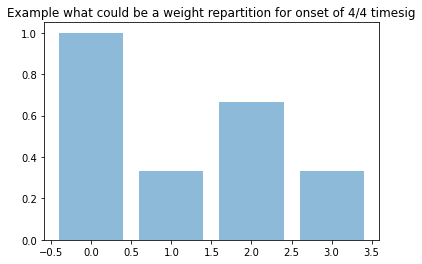

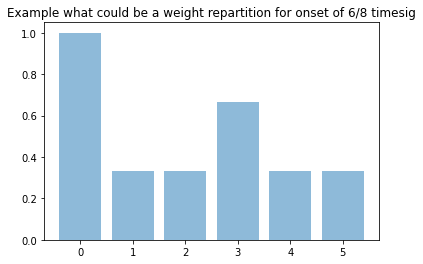

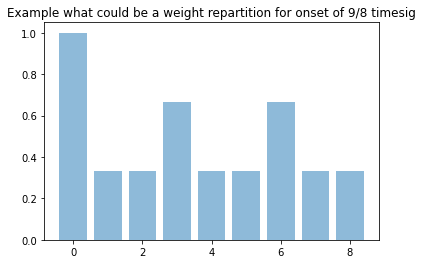

Normal
Numerator = 2: [2, 1]
Numerator = 3: [2, 1, 1]
Numerator = 4: [3, 1, 2, 1]
Numerator = 5: [2, 1, 1, 1, 1]
Numerator = 6: [3, 1, 1, 2, 1, 1]
Numerator = 7: [2, 1, 1, 1, 1, 1, 1]
Numerator = 8: [4, 1, 2, 1, 3, 1, 2, 1]
Numerator = 9: [3, 1, 1, 2, 1, 1, 2, 1, 1]
Normalized
Numerator = 2: [1.  0.5]
Numerator = 3: [1.  0.5 0.5]
Numerator = 4: [1.  0.3 0.7 0.3]
Numerator = 5: [1.  0.5 0.5 0.5 0.5]
Numerator = 6: [1.  0.3 0.3 0.7 0.3 0.3]
Numerator = 7: [1.  0.5 0.5 0.5 0.5 0.5 0.5]
Numerator = 8: [1.  0.2 0.5 0.2 0.8 0.2 0.5 0.2]
Numerator = 9: [1.  0.3 0.3 0.7 0.3 0.3 0.7 0.3 0.3]


In [67]:
from music_tools.midi_utils import get_updown_beats

plt.cla()
plt.bar(np.arange(4), height=get_updown_beats(4), alpha=0.5)
plt.title("Example what could be a weight repartition for onset of 4/4 timesig")
plt.show()
plt.title("Example what could be a weight repartition for onset of 6/8 timesig")
plt.bar(np.arange(6), height=get_updown_beats(6), alpha=0.5)
plt.show()
plt.title("Example what could be a weight repartition for onset of 9/8 timesig")
plt.bar(np.arange(9), height=get_updown_beats(9), alpha=0.5)
plt.show()

print("Normal")
for numerator in range(2,10):
    print(f"Numerator = {numerator}:", get_updown_beats(numerator, normalized=False))

print("Normalized")
for numerator in range(2,10):
    print(f"Numerator = {numerator}:",  np.round(get_updown_beats(numerator), 1))


pass

This concludes presentation on `MidiFrame`, `MidiTrackFrame` and other utils we saw to regularize midi files.

---
## Creating An Interesting Musical Scale Dataset

We realized that the occidental music world simplifies our task a lot with the paradigm of the 12 unique chromatic tones. This reduces a "scale" to a permutations of notes among 12 choices, in other words 4096 possibilities.<br/>
Among them we thought it would be more relevant to only consider combinations with 5 or above notes.<br/>
12 on/off choices also means we can script scales as a binary number which also a unique scale id representation: for example Major pattern is 101011010101 becomes in decimal 2766.
It was with a great pleasure that we realized that this system was used broadly by many people/datasets on internet.

Moreover, using a scale with an explicit tonic is simply a **roll** of the scale among the 12 indices. Similarly, certain scales are **rotations** of others: for examples all the diatonic modes *Major(Ionian), Dorian, Phrygian, Lydian, Mixolydian, Natural Minor(Aeolian), Locrian* are the same and only pattern, rotated by a certain shift. 

To make all this knowledge take shape we created `GeneralScale` and `Scale` classes (in `scales` module).<br/>
* `GeneralScale` is the pattern representation of scale. It doesn't take any tonic as we are only interested in its "pure" intervals.
* `Scale` inherit `GeneralScale` and is the tonic applied representation of scale. The major differencec is that it takes a tonic for input in addition to the "pure" intervals.

We first built certain hardcoded function to initialize well known scales. Passing the tonic to these function will return a `Scale` and not doing it will return a `GeneralScale` (By tonic chroma, we mean here the chromatic index (that will always result in an integer modulo 12).

In [68]:
from music_tools.scales import GeneralScale, Scale, diatonic_scale, harmonic_scale, melodic_scale, Mode

gscale_1 = diatonic_scale(mode=Mode.MAJOR)
gscale_2 = diatonic_scale(mode=Mode.LYDIAN)
gscale_3 = harmonic_scale(major=False)
gscale_4 = melodic_scale(major=True)

scale_1 = diatonic_scale(tonic_chroma=0, mode=Mode.MAJOR)
scale_2 = diatonic_scale(tonic_chroma=1,mode=Mode.LYDIAN)
scale_3 = harmonic_scale(tonic_chroma=2,major=False)
scale_4 = melodic_scale(tonic_chroma=3,major=True)

print(gscale_1, gscale_2, gscale_3, gscale_4, sep="\n")
print("__" * 30)

print(scale_1, scale_2, scale_3, scale_4, sep="\n")
print("__" * 30)

print(gscale_1)
print("Scale Bitmap:",gscale_1.scale_bitmap)
print("Scale ID:",gscale_1.scale_id)
print("Semitones Intervals:", gscale_1.semitone_intervals)
print("Semitones Gaps:", gscale_1.semitones)
print("Note count:", gscale_1.note_count)
print("__" * 30)

scale_5 = diatonic_scale(tonic_chroma=5, mode=Mode.MAJOR)
print(scale_5)
print("Chroma Bitmap:", scale_5.chroma_bitmap)
print("Chroma:", scale_5.chromas)
print("Notes:", scale_5.chromas_name)
print("Tonic Chroma:", scale_5.tonic_chroma)

Major Scale
Lydian Scale
Harmonic Minor Scale
Melodic Major Scale
____________________________________________________________
Major Scale in C
Lydian Scale in C#/Db
Harmonic Minor Scale in D
Melodic Major Scale in D#/Eb
____________________________________________________________
Major Scale
Scale Bitmap: 101011010101
Scale ID: 2773
Semitones Intervals: [ 0  2  4  5  7  9 11]
Semitones Gaps: [2 2 1 2 2 2 1]
Note count: 7
____________________________________________________________
Major Scale in F
Chroma Bitmap: 101011010110
Chroma: [ 5  7  9 10  0  2  4]
Notes: ['F' 'G' 'A' 'Bb' 'C' 'D' 'E']
Tonic Chroma: 5


These abstractions offers many methods that we will not describe here. Even though we didn't have time to documentate the code, the functionment should pretty clear in the source. <br/>

Since our classes were offering a lot of flexibility and we saw that our system would work well with other scale datasets, we tried to create an arbitrary subset for our tool. We crossed 2 datasets:
* http://allthescales.org/index.php
* https://github.com/la3lma/chordguesser/blob/master/src/main/resources/ScaleCodingJan2011.csv

And filter them to keep an interesting intersection on both technical and cultural points of view (all the processing has been done either on `scale_researches` module or manually for some precisions). 

It results in the file `scale_researches/scale_final_data.csv` (here as `SCALE_DATA`). It can be used with the function `scales.scale` and any scale in our dataset can be attained.

In [69]:
from music_tools.scales import SCALE_DATA
SCALE_DATA

,scale_bits,rotation_id,circular_distance,note_count,name
scale_id,,,,,
2197,100010010101,22677,0,5,"Raga Mamata (India), Major 6th, Aerathitonic"
2213,100010100101,22693,0,5,"Raga Hindol (India), Daritonic"
3154,110001010010,22693,1,5,"Kokin-Joshi (Japan), Japanese Soft Ascend, Miy..."
2836,101100010100,22693,3,5,"Dorian Pentatonic, Kumoi (Japan), Akebono (Japan)"
2648,101001011000,22693,8,5,Han kumoi (Japan)
...,...,...,...,...,...
3063,101111110111,44989,3,10,"Minor Pentatonic with Leading Tones, Solyllian"
3039,101111011111,44989,8,10,"Major & Minor mixed, Godyllian"
4031,111110111111,49087,0,11,Godatic


You can note that we computed the column `rotation_id` and `circular_distance`, these values help us track the scales that are among the same rotated families. Additionally, we gain from knowing the name and usage of scales in many other cultures and we think is's really enriching.

`rotation_id = (note_count << 12) | scale_id`, with the `scale_id` of the first encountered scale of a family while running over data (this way we can later compare other scale's rotations to see whether it's the same pattern). `circular_distance` is the distance needed to roll the scale until we reach the same pattern. In some cases, we reoredered families to have most common scales appearing first. <br/>
This is important because we use this fact to avoid doing redundant computations during scale suggestion, by computing our metric only on the zero-rotated scales (because we would obtain the same score with other scales of the same family if we had just shift the tonic accordingly).

Case where we did a bit of manual refactoring (diatonic families below with `rotation_id` at 31445):

In [70]:
SCALE_DATA.iloc[73:87]

,scale_bits,rotation_id,circular_distance,note_count,name
scale_id,,,,,
2517,100111010101,32089,4,7,"Houzam (Greece), Raga Saildesakshi, Trishuli (..."
2766,101011001110,32089,9,7,Mixolydian Augmented
2773,101011010101,31445,0,7,"Major, Ionian, Bilaval, Nid Murub (Sumerian), ..."
3434,110101101010,31445,1,7,"Locrian, Qablitum (Sumerian)"
2906,101101011010,31445,3,7,"Natural Minor, Aeolian, Gregorian 2, Assari Th..."
2774,101011010110,31445,5,7,"Mixolydian, Ching (China), Mitum (Sumerian), G..."
2741,101010110101,31445,7,7,"Lydian, Kalyan, IonianPing (China), Nis Garb.r..."
3418,110101011010,31445,8,7,"Phrygian, Bhairavi, Ishartum (Sumerian), Ousak..."
2902,101101010110,31445,10,7,"Dorian, Eskimo Heptatonic (N. America), Kafi T..."


We also have another group of scale-related preprocessed files we use in UI to navigate between scales. Since we will not describe it fully, I will briefly resume what it is. You have 2 main files, `scale_researches/scale_forest.pkl` and `scale_researches/scale_parents.pkl` which describe a made-up kind of graph which relates scales together based on their closest set-similarity.

Let's take an example: we could say that the Chromatic Scale is the parent of all others. But it wouldn't be interesting in termps of structure. Instead will find only its "direct" children... In other words, the biggest scale, that it can contains but no less. With this "arborescence" we can travel down the scales and see what are the closest patterns to our current one. On the reverse, it is not exactly a "tree", because one node can have several parents. But still with condition that they are the closest in set-difference (this is exploited in the UI with **parents scales** and **children scales** ans also available in `Scale`, `GeneralScale` API). We thought of using this structure to optimize our computations for scale suggestions, but it revealed uneeded.

You can see an example below with the General Major Scale (if you take always a parent at random you are certified to reach the Chromatic Scale at some point):

In [71]:
from music_tools.scales import SCALE_FOREST, SCALE_PARENTS
print(SCALE_FOREST[2773])
print(SCALE_PARENTS[2773])

# With Scale API:
c_major_scale = diatonic_scale(0, mode=Mode.MAJOR)

print("Grand Children:",c_major_scale.child_scales()[0].child_scales()[0].child_scales())
print("Children:",c_major_scale.child_scales()[0].child_scales())
print("Scale:",c_major_scale)
print("Parents:",c_major_scale.child_scales())
print("Grand Parents:",c_major_scale.parent_scales())
print("Great Grand Parents:", c_major_scale.parent_scales()[0].parent_scales())
print("Root:", c_major_scale.parent_scales()[0].parent_scales()[0].parent_scales())

{'self': 2773, 2709: {'self': 2709, 2708: {'self': 2708}, 2197: {'self': 2197}}, 2644: {'self': 2644}}
[2775, 2805, 2781]
Grand Children: []
Children: [Major Pentatonic Scale in C, Raga Mamata (India) Scale in C]
Scale: Major Scale in C
Parents: [Lydian Hexatonic Scale in C, Ritusen (Japan) Scale in C]
Grand Parents: [Dominant Bebop Scale in C, Major Lydian Scale in C, Major Bebop Scale in C]
Great Grand Parents: [Major & Minor mixed Scale in C, Lydian Mixolydian Taishikicho Scale in C, Chromatic Bebop Scale in C]
Root: [Chromatic Scale in C]


---
## Scale Suggestions

We knew from the beginning that we wanted to avoid data-driven methods (such as Machine Learning) on such a short worktime window, because there is always a chance to get unexplainable/unreliable results when we design them ourself. 

We tried to come up with an annalytic solution to detect a scale solely on a group of notes comprised in a window of several bars.
Let's lead the demo of what is going on in our program:

First we take bars 4 to 10 of the playing track frame computer earlier and we then convert its `midi_ids` to `chroma_ids` (0 to 11).

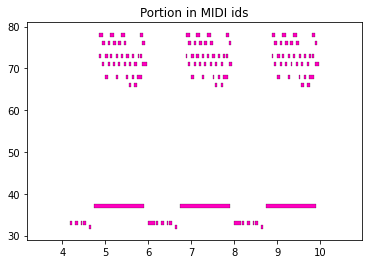

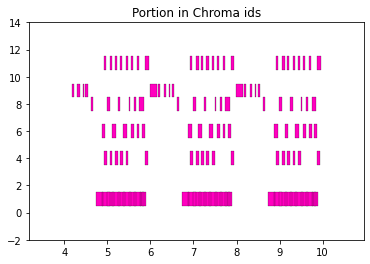

In [77]:
from music_tools.midi_utils import plot_music, to_chroma, CHROMA_IDS

# We take the notes from bar 4 to bar 10
music_portion = midiframe.playing_track_frame.get_sub_dataframe(4, 10, metric="bartime")
plot_music(music_portion, metric="bartime")
plt.title("Portion in MIDI ids")
# Set in chromas
music_portion_chromas = to_chroma(music_portion.note.to_numpy())
plot_music(music_portion, chroma_plot=True, metric="bartime")
plt.title("Portion in Chroma ids")
pass

Then we compute count for each note in the portion and display it on the 12 notes space (parameter *weight* here corresponds to the aforementioned updown_beat optional ponderation, we set it to None for this demo):

In [79]:
unique_music_chromas, counts = np.unique(music_portion_chromas, return_counts=True)
weights = None
if weights is not None:
    counts = np.array([weights[music_portion_chromas == chroma].sum() for chroma in unique_music_chromas])
chroma_counts = np.zeros(12)
chroma_counts[unique_music_chromas] = counts
portion_chroma_counts, portion_chroma_counts_sum = chroma_counts, chroma_counts.sum()

print("Counts based on found notes:", unique_music_chromas, counts)
print("Counts with Chroma position:", chroma_counts)

Counts based on found notes: [ 1  4  6  8  9 11] [30 18 18 18 14 24]
Counts with Chroma position: [ 0. 30.  0.  0. 18.  0. 18.  0. 18. 14.  0. 24.]


Below is a modified copy of the core function to understand the scales suggestions: `scales.compute_accuracy`
* We pass a list of scales from which we want score.
* We pass the counts and sum we just computed
* We pass the allowed tonic chromas (was left as a feature but never altered, it will always take the 12 chromas)
* We pass if the final accuracy should be normalized between them (min-> 0, max -> 1)

Each scales is decomposed as its bitmap in an array (for example, Major -> `[1,0,1,0,1,1,0,1,0,1,0,1]`) then rolled and repeated for each tonic chroma.
This way we can compute sort of correlations with the counts shown just before by doing scalar product with scale vectors.
For example:  `[0,30,0,0,18,0,18,0,18,14,0,24] @ [1,0,1,0,1,1,0,1,0,1,0,1] = 56`

Every single needed object is vectorized to leverage from numpy power.

We tried to make up for 2 kinds of correlations:
* `score`: How much the played notes fall correctly on the scales. Mathematically, if the played chromas fall perfectly on the scale, the dot product will be maximized. If the played notes completely fell off, you minimize the score. This implies that Chromatic Scale will always have a score of 100%, which is undesirable.
* `matching`: To cope with the aforementioned problem, we add the `matching` to compensate for the fact that even though played notes have perfect score with the scale, it is maybe matching less than necessary. This metric consists in takin one minus the absolute differences between the chromatic note presence and the scale notes appearance divided by the largest possible matching difference with the scale note count. It tries to answer the question how perfectly we fall **only** among the scale notes.

We multiply both metrics to get a fair accuracy and we should have a long list of len(tonic_chromas) * len(general_scale_susbet) in principle.
We then reshape the result to make it match in row the scales, and in columns the tonic_chromas.
We have accuracy for every input possibility (scale, tonic) and just need to compare them afterward to find the best.

In [92]:
from music_tools.scales import ALL_GENERAL_ROTZERO_SCALES

def compute_accuracy(general_scale_subset: list,
                    music_chroma_counts: np.ndarray, 
                    music_chroma_counts_sum: float,
                    tonic_chromas=CHROMA_IDS,
                    normalize_accuracy=True):
    
    scales_matrix = np.array([gs.scale_bitmap.as_array() for gs in general_scale_subset])
    scales_matrix = np.vstack([np.roll(scales_matrix, tonic, axis=1) for tonic in tonic_chromas])
    
    print("Scale Matrix:")
    print(scales_matrix)
    
    scales_note_count = np.array([gs.note_count for gs in general_scale_subset]).T
    scales_note_count = np.tile(scales_note_count, len(tonic_chromas))
    
    print("Scale note count:")
    print(scales_note_count)
    
    scores = (scales_matrix @ music_chroma_counts / music_chroma_counts_sum - 0.5) * 2
    # Equivalent:
    # scores = (np.sum(scales_matrix * music_chroma_counts, axis=1) / music_chroma_counts_sum - 0.5) * 2  
    
    over_max_match_diff = 1.0/(6 + np.abs(6 - scales_note_count))
    
    matching = 1 - np.einsum("ij,i->i" ,np.abs(music_chroma_counts / music_chroma_counts.max() - scales_matrix), over_max_match_diff)
    # Equivalent:
    # matching = 1 - np.sum(np.abs(music_chroma_counts / music_chroma_counts.max() - scales_matrix), axis=1) * over_max_match_diff
    
    print("Scores:")
    print(scores)
    print("Matchings:")
    print(matching)
    accuracy = scores * matching
    if normalize_accuracy:
        accuracy_min = accuracy.min()
        accuracy = (accuracy - accuracy_min) / (accuracy.max() - accuracy.min())
    
    print("Before reshape")
    print(accuracy)
    
    results = accuracy.reshape(len(general_scale_subset), -1, order="F")
    print("After reshape")
    print(results)
    return results




We will display below an example with a unique scale taken in account:

In [93]:
compute_accuracy(ALL_GENERAL_ROTZERO_SCALES[:1], 
                 music_chroma_counts=portion_chroma_counts, 
                 music_chroma_counts_sum=portion_chroma_counts_sum, 
                 normalize_accuracy=True)
pass

Scale Matrix:
[[1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1.]
 [1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1.]
 [1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0.]
 [0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1.]]
Scale note count:
[5 5 5 5 5 5 5 5 5 5 5 5]
Scores:
[-0.08196721 -0.21311475  0.40983607 -1.          0.47540984 -0.47540984
 -0.21311475 -0.01639344 -0.70491803  0.60655738 -0.7704918  -0.01639344]
Matchings:
[ 0.23809524  0.16190476  0.52380952 -0.2952381   0.56190476  0.00952381
  0.16190476  0.27619048 -0.12380952  0.63809524 -0.16190476  0.27619048]
Before reshape
[0.03555556 0.         0.59111111 0.78222222 0.71555556 0.07111111
 0.         0.07111111 0.28888889 1.         0.37777778 0.07111111]
After resh

We will display below an example with a 3 scales taken in acccount:

In [94]:
compute_accuracy(ALL_GENERAL_ROTZERO_SCALES[:3], 
                 music_chroma_counts=portion_chroma_counts, 
                 music_chroma_counts_sum=portion_chroma_counts_sum, 
                 normalize_accuracy=True)

Scale Matrix:
[[1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1.]
 [1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1.]
 [1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1.]
 [1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0.]
 [1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0.]
 [1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0.]
 [0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0.]
 [1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1.]
 [0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1.]
 [0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1.]
 [1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0.]
 [1. 0. 1. 

array([[3.55555556e-02, 6.58423933e-17, 5.91111111e-01, 7.82222222e-01,
        7.15555556e-01, 7.11111111e-02, 6.58423933e-17, 7.11111111e-02,
        2.88888889e-01, 1.00000000e+00, 3.77777778e-01, 7.11111111e-02],
       [2.88888889e-01, 9.33333333e-02, 7.15555556e-01, 3.77777778e-01,
        1.46666667e-01, 3.55555556e-02, 2.88888889e-01, 7.15555556e-01,
        2.88888889e-01, 4.26666667e-01, 7.11111111e-02, 4.44444444e-03],
       [3.77777778e-01, 0.00000000e+00, 1.46666667e-01, 2.22222222e-02,
        3.55555556e-02, 5.91111111e-01, 2.88888889e-01, 2.48888889e-01,
        3.55555556e-02, 9.33333333e-02, 4.44444444e-03, 1.77777778e-01]])

It revealed itself pretty efficient. Even in the worst case it stays below 2-3ms (with a relatively recent PC config), you can benchmark it below with the real implementation.

In [95]:
mf = MidiFrame(midofile)
mf.make_playing_track_frame(np.arange(16))

In [96]:
%timeit -r 4 -n 1000 suggestions = mf.playing_track_frame.suggest_scale(start=0, end=100, weighted=False, normalize_accuracy=True, threshold=-1)

2.08 ms ± 9.42 µs per loop (mean ± std. dev. of 4 runs, 1,000 loops each)


We didn't get time to fully investigate how good were the suggestions, but it didn't look absurd most of time on our little tests

---
## Chord Suggestions

In [4]:
# Imports
import mido
import numpy as np
from itertools import combinations
from music_tools.midi_frame import MidiFrame
import music_tools.scales as scales
import music_tools.midi_utils as mu
from music_tools.chords import ChordSuggester

In [5]:
# Load a track
name = "Vivaldi Concerto.mid"
m = mido.MidiFile(filename="MIDI_Files/" + name)
mf = MidiFrame(m, info_type="dispatched")
mf.make_playing_track_frame([i for i in range(16)])

# Choose a time window to detect the scale from
bartime_start = 0
bartime_end = 10
music_dataframe = mf.playing_track_frame.get_sub_dataframe(bartime_start, bartime_end)

We start by taking the best scale detected from the section above and use this scale to generate chords suggestions.

We then select the different parameters for the chords suggestions, including :
- Number of notes per chord
- Number of chords to generate
- Similarity : We measure how similar the notes in the chord are relative to the notes in the time window selected. This increases the probability to get a good sounding chord played at the same time as the song, though 
- Harmony : We give importance to the notes detected to be the tonic, the major/minor third and the dominant in order to get more logical chords
- Consonance : We use the Equal Temperant fraction numerators to give a score based on the quality of intervals in the possible chords. This for example promotes the intervals with major third or a perfect fifth and reduces the likeliness of suggesting a tritone.
- Weighted beat : We give more importance to the notes that occur on the principal beat

In [8]:
# Find the best scale detected
scale = scales.suggest_scales(mu.to_chroma(music_dataframe.note.to_numpy()))[0]
scale = scale[0].scale_in(scale[1])
print("Scale detected")
print(scale)
print(mu.CHROMA_NAMES[scale.chromas])
print("===================================")

# Settings for the suggested chords
note_count = 3 # number of notes per chord
chord_count = 5 # number of chords displayed (not a problem if more than nb of combinations)
similarity = 0.8
harmony = 0.9
consonance = 1.0
beat_weighted = False
sug = ChordSuggester(scale, music_dataframe, note_count=note_count, w_similarity=similarity,
                     w_harmony=harmony, w_consonance=harmony, beat_weighted=beat_weighted)
chords = sug.suggest_chords(chord_count)
print("Suggested chords to go along")
print(mu.CHROMA_NAMES[sug.suggest_chords(chord_count)])

Scale detected
Major Scale in C
['C' 'D' 'E' 'F' 'G' 'A' 'B']
Suggested chords to go along
[['C' 'E' 'A']
 ['D' 'E' 'A']
 ['E' 'A' 'B']
 ['E' 'F' 'A']
 ['E' 'G' 'A']]


The detected scale is the major scale in C which contains the same key as the minor scale in A from the Concerto of Vivaldi used here.

The first chord suggested is indeed the most appropriate that fits the detected scale as expected!